In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.common.action_chains import ActionChains
import time
import requests
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
driver = webdriver.Chrome()
driver.maximize_window()

# explicit wait 
wait = WebDriverWait(driver, 3) 


def wait_pageLoading(driver, wait):
    page_title = driver.title
    try:
        wait.until(
            lambda d : d.execute_script("return document.readyState") == "complete"
        )
    except:
        print(f"The page \"{page_title}\" did not get loaded fully")
    finally:
        print(f"The page \"{page_title}\" got loaded succesfully")

url = 'https://www.nykaa.com/?root=logo'

driver.get(url)
wait_pageLoading(driver, wait)

# loacting the search box
search_bar = wait.until(
    EC.element_to_be_clickable((By.XPATH, "//input[@placeholder='Search on Nykaa']"))
)
search_bar.click()
search_bar.send_keys("korean skin care")
search_bar.send_keys(Keys.ENTER)

wait_pageLoading(driver, wait)

all_products = []
previous_count = 0

while True:

    product_container = driver.find_element(By.ID, 'product-list-wrap')
    products = product_container.find_elements(By.XPATH, ".//div[contains(@class,'productWrapper')]")
    current_count = len(products)

    if current_count == previous_count:
        break

    for product in products[previous_count: current_count]: 
        try:
            name = product.find_element(By.XPATH, ".//div[contains(@class,'css-xrzmfa')]").text
        except:
            name = "NA"
        try:
            price = product.find_element(By.CLASS_NAME, "css-111z9ua").text
        except:
            price = "NA"
        try:
            review = product.find_element(By.CLASS_NAME, "css-1qbvrhp").text
        except:
            review = "NA"

        # appending the data 
        all_products.append(
            {
                'product_name': name,
                'price': price,
                'review_no': review
            }
        )

    previous_count = current_count

    # loacting to load_more contents btn
    try:
        load_more = wait.until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="load-more"]'))
        )

        # scrolling to next_btn 
        driver.execute_script("arguments[0].scrollIntoView({block:'center'});", load_more)
        time.sleep(2)
        load_more.click()
        # wait_pageLoading(driver, wait)

        wait.until(
            lambda d: len(
                d.find_element(By.ID, "product-list-wrap")
                 .find_elements(By.XPATH, ".//div[contains(@class,'productWrapper')]")
            ) > previous_count
        )
    except:
        print("The next button is not clickable, we have navigated through all the pages")
        break

driver.close()

df = pd.DataFrame(all_products)
df.to_csv("koran_skin_care.csv", index=False)

The page "Buy Cosmetics Products & Beauty Products Online in India at Best Price | Nykaa" got loaded succesfully
The page "Buy Cosmetics Products & Beauty Products Online in India at Best Price | Nykaa" got loaded succesfully
The next button is not clickable, we have navigated through all the pages


In [17]:
df = pd.read_csv('koran_skin_care.csv')

In [18]:
df.rename(columns={'review_no': 'review_count'}, inplace=True)

In [19]:
df['review_count'] = df['review_count'].astype('str')

In [20]:
# handled price
df['price']=df['price'].str.replace('₹', '').str.strip()
df['price'] = pd.to_numeric(df['price'])

In [29]:
df['review_count'] = df['review_count'].str.replace("-", '').str.strip()
df['review_count'] = pd.to_numeric(df['review_count'])

In [43]:
df.sort_values(by='price', ascending=False)

,product_name,price,review_count
623,Sulwhasoo Concentrated Ginseng Rejuvenating Ey...,9000,8.0
1043,Korean Beauty Box - Limited Edition Giftset,8586,2.0
791,VT Cosmetics PDRN Reedle Shot 700,6299,1.0
199,Sulwhasoo Essential Firming Cream,6250,NaN
629,Sulwhasoo Overnight Repair Ritual Combo,6200,1586.0
...,...,...,...
1148,ManCode Rose Facial Sheet Mask For Refreshing ...,44,4.0
311,Sanfe Instant Detan Charcoal Facial Mask,44,82.0
1142,ManCode Green Tea Facial Sheet Mask For Purifi...,44,8.0
1144,ManCode Charcoal Facial Sheet Mask For Unclog ...,44,10.0


In [ ]:
df[['price', 'review_count']].corr()

# no strong relationship between these two columns

,price,review_count
price,1.000000,-0.195466
review_count,-0.195466,1.000000


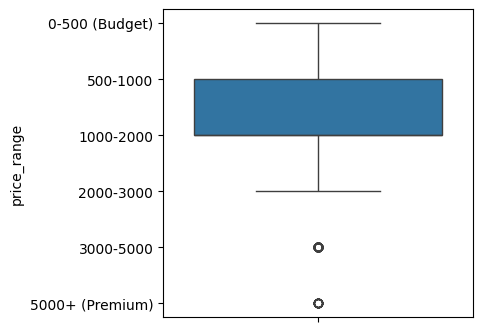

In [93]:
plt.figure(figsize=(4,4))
sns.boxplot(df['price_range'])

plt.show()


In [88]:
print(df['price'].skew())


1.6114854558814211


In [66]:
df['price'].describe()

count    1224.000000
mean     1455.549837
std      1070.915297
min        44.000000
25%       698.000000
50%      1345.500000
75%      1905.250000
max      9000.000000
Name: price, dtype: float64

In [75]:
bins = [0, 500, 1000, 2000, 3000, 5000, 10000]

labels = [
    "0-500 (Budget)",
    "500-1000",
    "1000-2000",
    "2000-3000",
    "3000-5000",
    "5000+ (Premium)"
]

df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

In [79]:
df['price_range'].value_counts().sort_index(ascending=False)

price_range
5000+ (Premium)     15
3000-5000           68
2000-3000          193
1000-2000          496
500-1000           217
0-500 (Budget)     235
Name: count, dtype: int64

In [81]:
df.groupby('price_range')['review_count'].mean().sort_values()

price_range
5000+ (Premium)       236.777778
500-1000             2700.720000
1000-2000            2745.101990
3000-5000            3939.163636
2000-3000            4068.843972
0-500 (Budget)     825143.846847
Name: review_count, dtype: float64

In [138]:
analysis = df.groupby('price_range').agg({
    'product_name': 'count',
    'review_count': ['mean', 'median']
})

analysis

product_name   review_count       
                       count           mean median
price_range                                       
0-500 (Budget)           235  825143.846847  191.0
500-1000                 217    2700.720000  104.0
1000-2000                496    2745.101990   17.5
2000-3000                193    4068.843972   22.0
3000-5000                 68    3939.163636   11.0
5000+ (Premium)           15     236.777778    4.0

In [101]:
# the 0-500 segment if the affordable range of prodcuts with good number of reviews 
# however, the sweet spot for the korean products fall within the range of 500-2000
# this shows that majority of people buy products in this range 
# but as we move to higher price , review count decreases considerably 
# very few traction has engagement to premium products 
# so korean products with higher price range is not preferred by the mass 
# also , the review are not so good in higher price segments
# this also supports the correlation value that -0.19 that showed negetaive relationship 

In [85]:
df.groupby('price_range')['review_count'].median()

price_range
0-500 (Budget)     191.0
500-1000           104.0
1000-2000           17.5
2000-3000           22.0
3000-5000           11.0
5000+ (Premium)      4.0
Name: review_count, dtype: float64

<Axes: xlabel='price', ylabel='review_count'>

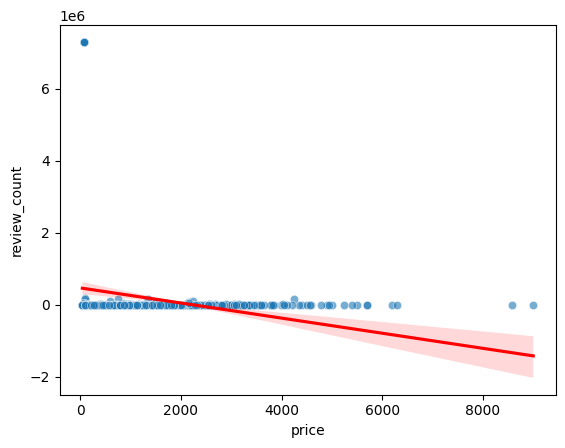

In [118]:
sns.scatterplot(data=df, x='price', y='review_count', alpha=0.6)
sns.regplot(data=df, x='price', y='review_count', scatter=False, color='red')
# plt.yscale('log')

In [120]:
num_col = ['price', 'review_count']
for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]

    print(f"\nColumn: {col}")
    print(f"Lower Bound: {lower}")
    print(f"Upper Bound: {upper}")
    print(f"Number of Outliers: {len(outliers)}")


Column: price
Lower Bound: -1112.875
Upper Bound: 3716.125
Number of Outliers: 43

Column: review_count
Lower Bound: -715.5
Upper Bound: 1208.5
Number of Outliers: 163


In [130]:
new_df = df[df['review_count'] < upper]
new_df['review_count'].skew()

np.float64(2.1930251724156973)

In [131]:
print(df['review_count'].skew())

6.186697834637945


<Axes: ylabel='price_range'>

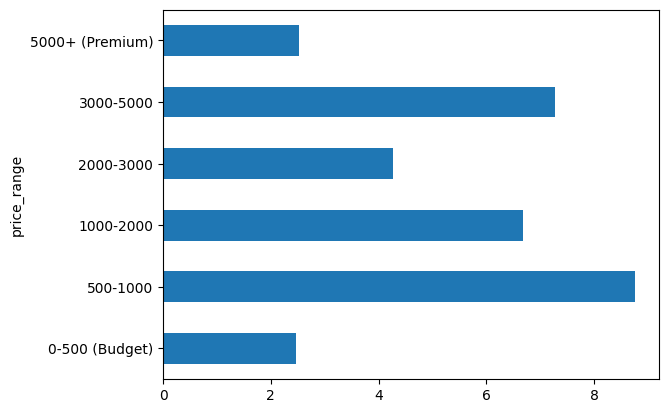

In [142]:
df.groupby('price_range')['review_count'].skew().plot(kind='barh')

In [126]:
df.loc[df['review_count'].idxmax()]

product_name    Nykaa Green Tea + Aloe Vera Sheet Mask For Hyd...
price                                                          80
review_count                                            7299638.0
price_range                                        0-500 (Budget)
Name: 51, dtype: object